# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
⊗ = kron;

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Project.toml`
  No Changes to `~/Documents/GitHub/robust_control_sam/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.Pr

In [3]:
# Problem parameters
T = 20
Δt = 0.2
iSWAP = exp(1.0im * π / 4 * (PAULIS.X ⊗ PAULIS.X + PAULIS.Y ⊗ PAULIS.Y))
SWAP = ComplexF64[1 0 0 0;
                    0 0 1 0;
                    0 1 0 0;
                    0 0 0 1]
U_goal = iSWAP

X1 = GATES.X ⊗ GATES.I
Y1 = GATES.Y ⊗ GATES.I
Z1 = GATES.Z ⊗ GATES.I
X2 = GATES.I ⊗ GATES.X
Y2 = GATES.I ⊗ GATES.Y
Z2 = GATES.I ⊗ GATES.Z
XX = GATES.X ⊗ GATES.X # transversal coupling
YY = GATES.Y ⊗ GATES.Y # transversal coupling
ZZ = GATES.Z ⊗ GATES.Z # transverse coupling, for error comparison

H_drive = [X1, Y1, Z1, X2, Y2, Z2, ZZ] # single qubit controls + tunable coupling
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 4, n_drives = 7

sanity checks for our good ole adjoint

In [4]:
Random.seed!(5)
# uni_prob = UnitaryUniversalProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts
#     )

# solve!(uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
# solve!(uni_prob, max_iter=20, print_level=5)

f_uni_prob = UnitaryUniversalProblem(
    sys, U_goal, T, Δt, a_bound=2.0, dda_bound=5.0;
    activate_speedboost=false,
    piccolo_options=piccolo_opts
    )
solve!(f_uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
#solve!(f_uni_prob, max_iter=20, print_level=5)

# rf_uni_prob = UnitaryUniversalProblem(
# sys, U_goal, T, Δt;
# piccolo_options=piccolo_opts
# )
# solve!(rf_uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
# solve!(rf_uni_prob, max_iter=20, print_level=5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt, a_bound=2.0, dda_bound=5.0; Q_t=1.0)
solve!(def, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(def, max_iter=20, print_level=5)

#Adjoint
# ∂ₑHₐ = [X1, Y1, Z1, X2, Y2, Z2, ZZ] # try to achieve universal robustness with variational approach
# varsys_add = VariationalQuantumSystem(
#     H_drive,
#     ∂ₑHₐ,
# )

# Multiplicative error template
# H = aX
# H_drive_m = a -> a[1] * H_drive
# H_vars_array = Function[H_drive_m]

# varsys_mult = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     Function[a -> a[1] * PAULIS.X],
#     2
# )

# varsys_both = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
#     2
# )

# varadd_prob = UnitaryVariationalProblem(
#         varsys_add, U_goal, T, Δt;
#         robust_times=[[T]],
#         dda_bound = 2.0,
#         piccolo_options=piccolo_opts
#     )

# solve!(varadd_prob, max_iter=500, print_level=1, options=IpoptOptions(eval_hessian=false))
#solve!(varadd_prob, max_iter=20, print_level=5)


    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:    24768
Number of nonzeros in inequality constraint Jacobian.:        0
Number of no

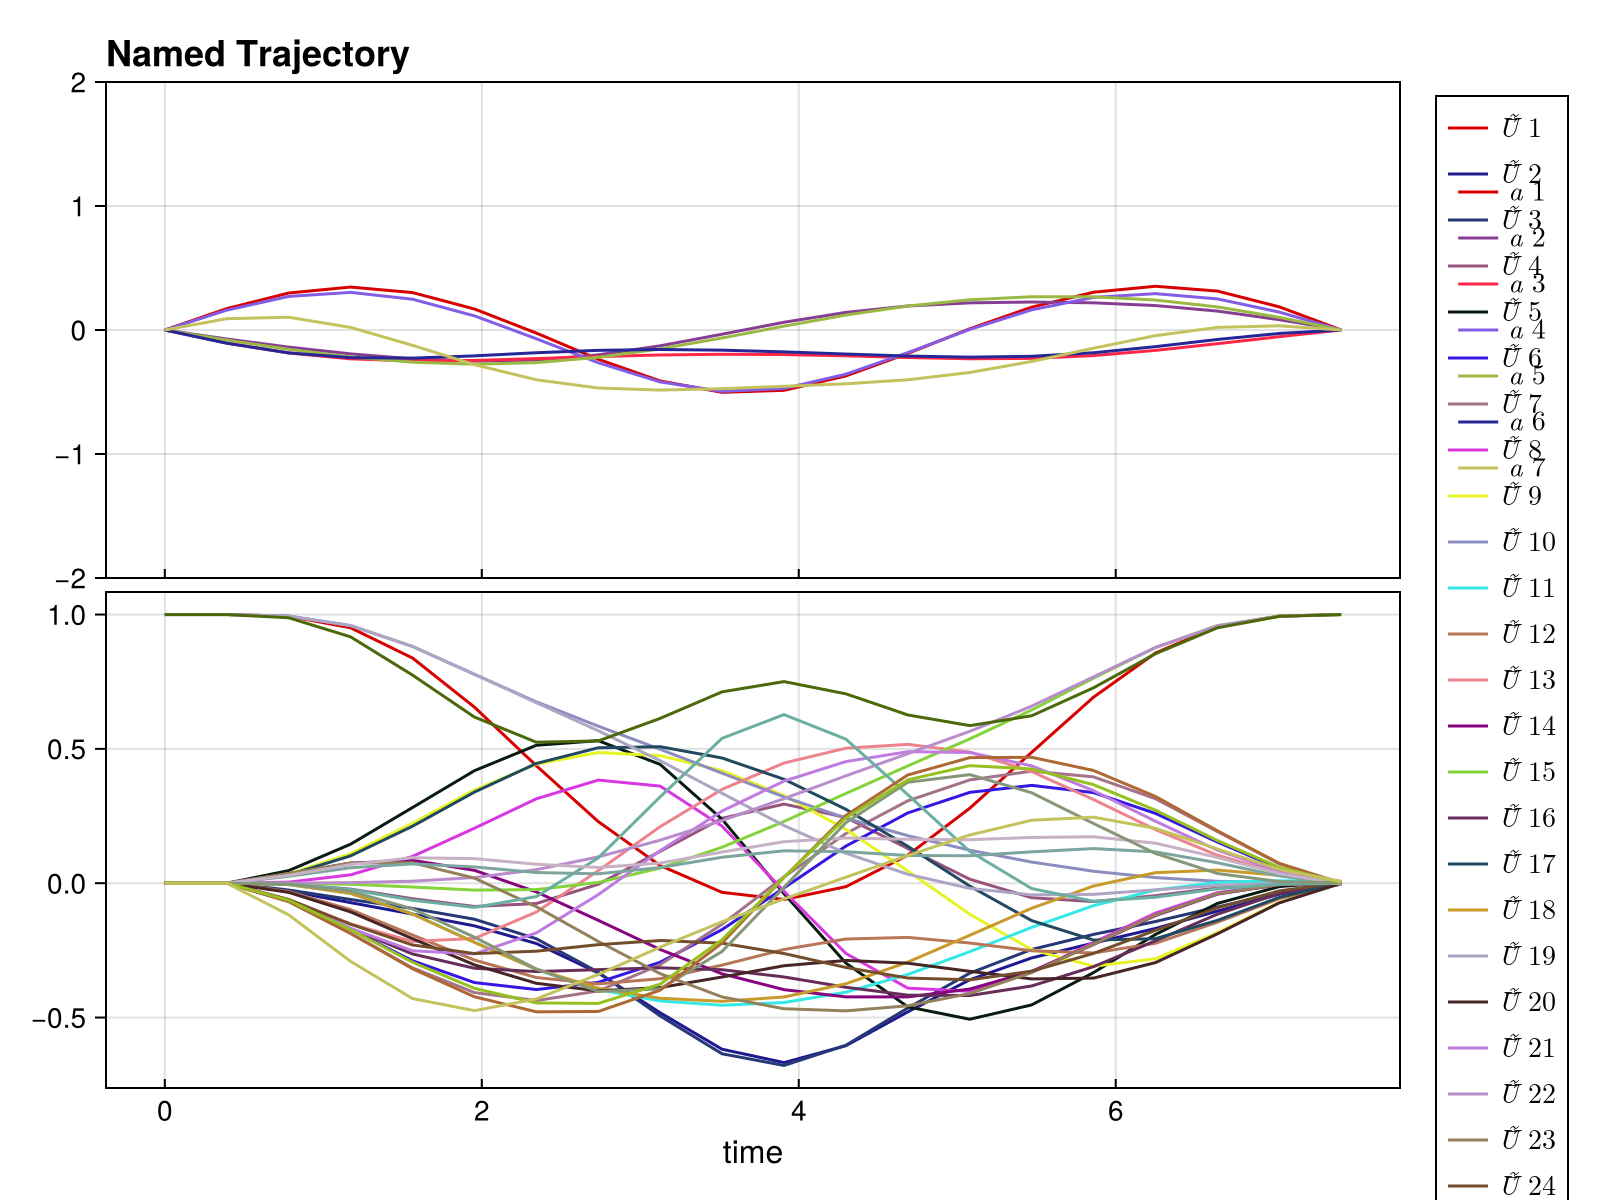

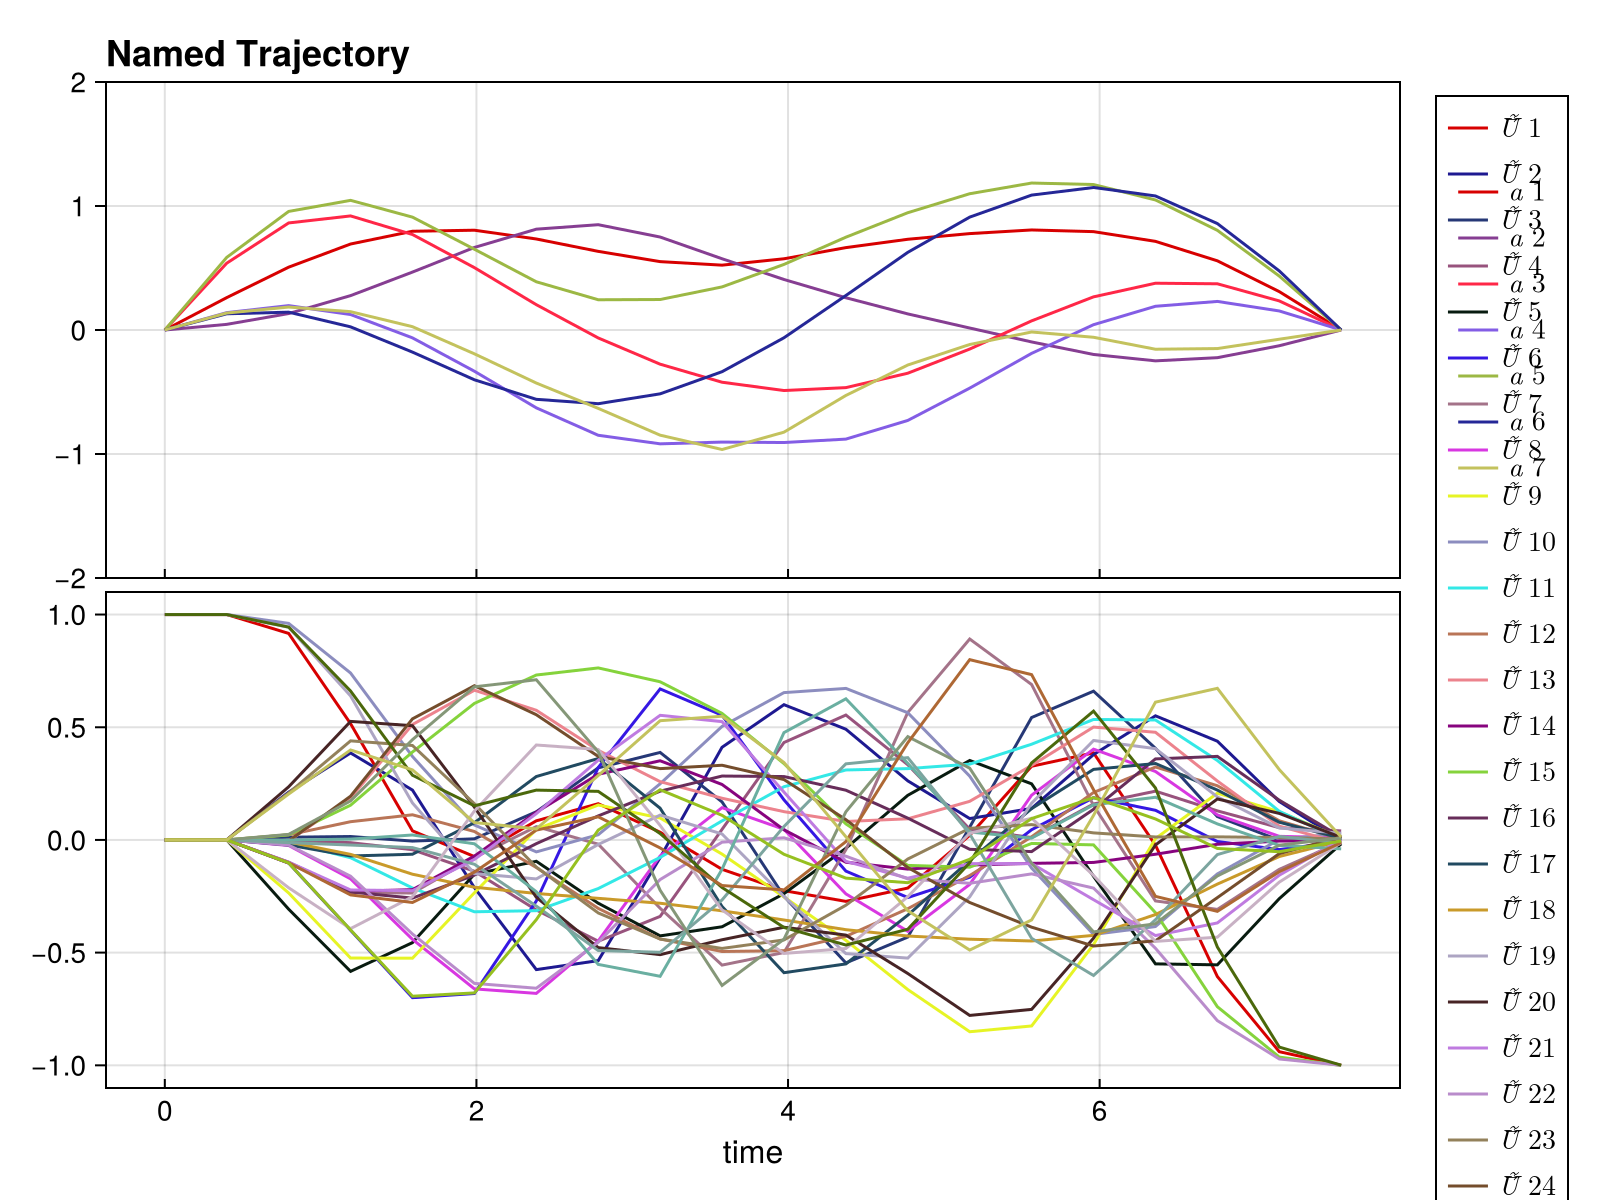

CairoMakie.Screen{IMAGE}


In [5]:
p1 = CairoMakie.plot(def.trajectory, [:a, :Ũ⃗])
#p2 = CairoMakie.plot(varadd_prob.trajectory, [:a, :Ũ⃗])
p3 = CairoMakie.plot(f_uni_prob.trajectory, [:a, :Ũ⃗])

display(p1)
#display(p2)
display(p3)

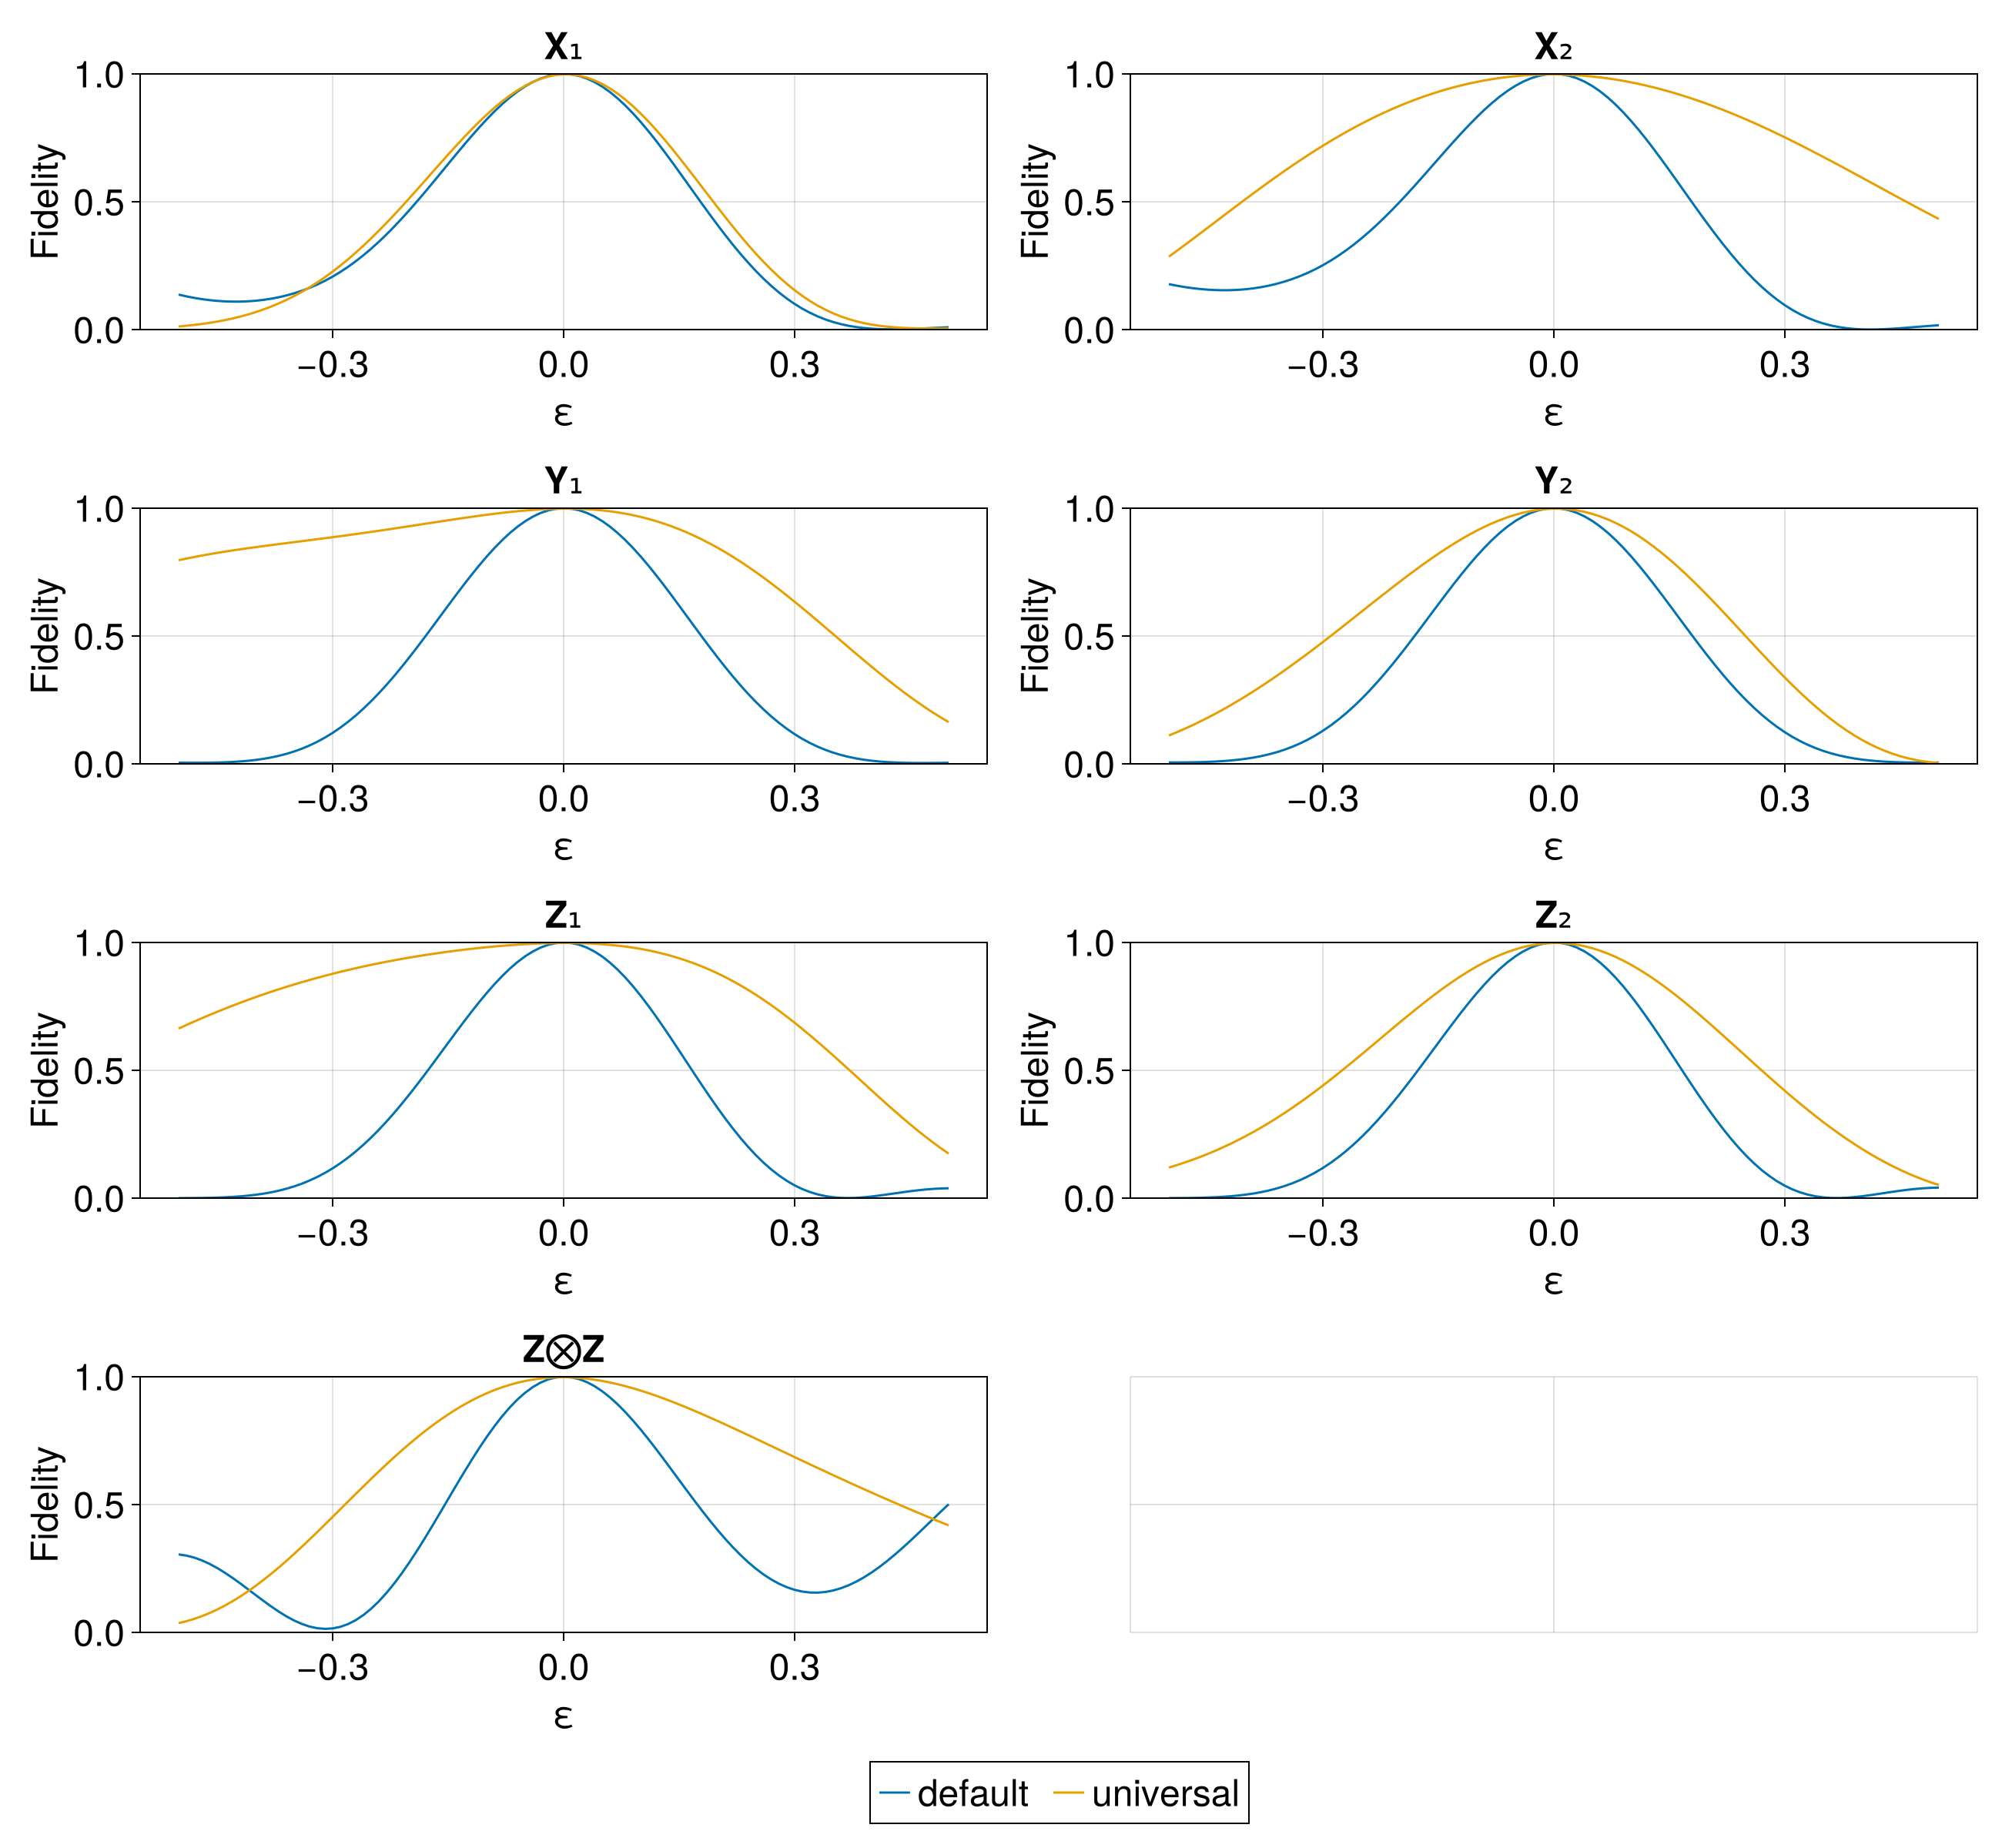

In [6]:
using CairoMakie

# --- Error ops & names (assumes X1,Y1,Z1,X2,Y2,Z2,ZZ already defined) ---
err_ops   = [X1, Y1, Z1, X2, Y2, Z2, ZZ]
err_names = ["X₁","Y₁","Z₁","X₂","Y₂","Z₂","Z⨂Z"]

# --- Problems to compare (assumes `def`, `f_uni_prob`, and H_drive exist) ---
problems = [
    (def,        "default"),
    (f_uni_prob, "universal"),
    #(varadd_prob,"variational"),
]

# Sweep & style
εs     = -0.5:0.01:0.5
colors = Makie.wong_colors()

# Helper: extract drive set to avoid DimensionMismatch
get_drives(prob) = hasproperty(prob, :system) && hasproperty(prob.system, :G) ? prob.system.G : H_drive

# Fidelity curve
fidelity_curve(prob, err_op) = [
    unitary_rollout_fidelity(prob.trajectory, QuantumSystem(ε * err_op, get_drives(prob)))
    for ε in εs
]

# --- Figure & layout (2 columns for plots; bottom row legend) ---
f = Figure(fontsize = 24, size = (1300, 1200), padding = 16)
rowgap!(f.layout, 18)
colgap!(f.layout, 22)

# Left column -> X1,Y1,Z1,ZZ ; Right column -> X2,Y2,Z2 ; keep (4,2) blank
left_indices  = [1, 2, 3, 7]  # X1,Y1,Z1,ZZ
right_indices = [4, 5, 6]     # X2,Y2,Z2

for (r, idx) in enumerate(left_indices)
    name, op = err_names[idx], err_ops[idx]
    ax = Axis(f[r, 1], title = name, xlabel = "ε", ylabel = "Fidelity")
    Makie.ylims!(ax, 0, 1)
    for (i, (prob, _)) in enumerate(problems)
        lines!(ax, εs, fidelity_curve(prob, op); color = colors[i], linestyle = :solid)
    end
end

for (r, idx) in enumerate(right_indices)
    name, op = err_names[idx], err_ops[idx]
    ax = Axis(f[r, 2], title = name, xlabel = "ε", ylabel = "Fidelity")
    Makie.ylims!(ax, 0, 1)
    for (i, (prob, _)) in enumerate(problems)
        lines!(ax, εs, fidelity_curve(prob, op); color = colors[i], linestyle = :solid)
    end
end

# Bottom-right placeholder to keep panel sizes matched
ax_blank = Axis(f[4, 2]); hidespines!(ax_blank); hidedecorations!(ax_blank, grid = false)

# Shared legend on a new bottom row spanning both columns
labels  = [label for (_, label) in problems]
handles = [Makie.LineElement(color = colors[i], linestyle = :solid) for (i, _) in enumerate(problems)]
Legend(f[5, 1:2], handles, labels; title = "Legend", orientation = :horizontal)

f

# Verify first-order robustness with space curve approach

In [23]:
using NamedTrajectories

pauli_strings = [X1, Y1, Z1, X2, Y2, Z2, XX, YY, ZZ] 
uni_traj = f_uni_prob.trajectory
default_traj = def.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(op * first_order_terms[t] / (d * T))) for op in pauli_strings] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [24]:
abs(tr(SWAP' * iso_vec_to_operator(def.trajectory.Ũ⃗[:, 1])))/4

0.5

In [25]:
SWAP

4×4 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/scenes.jl:238


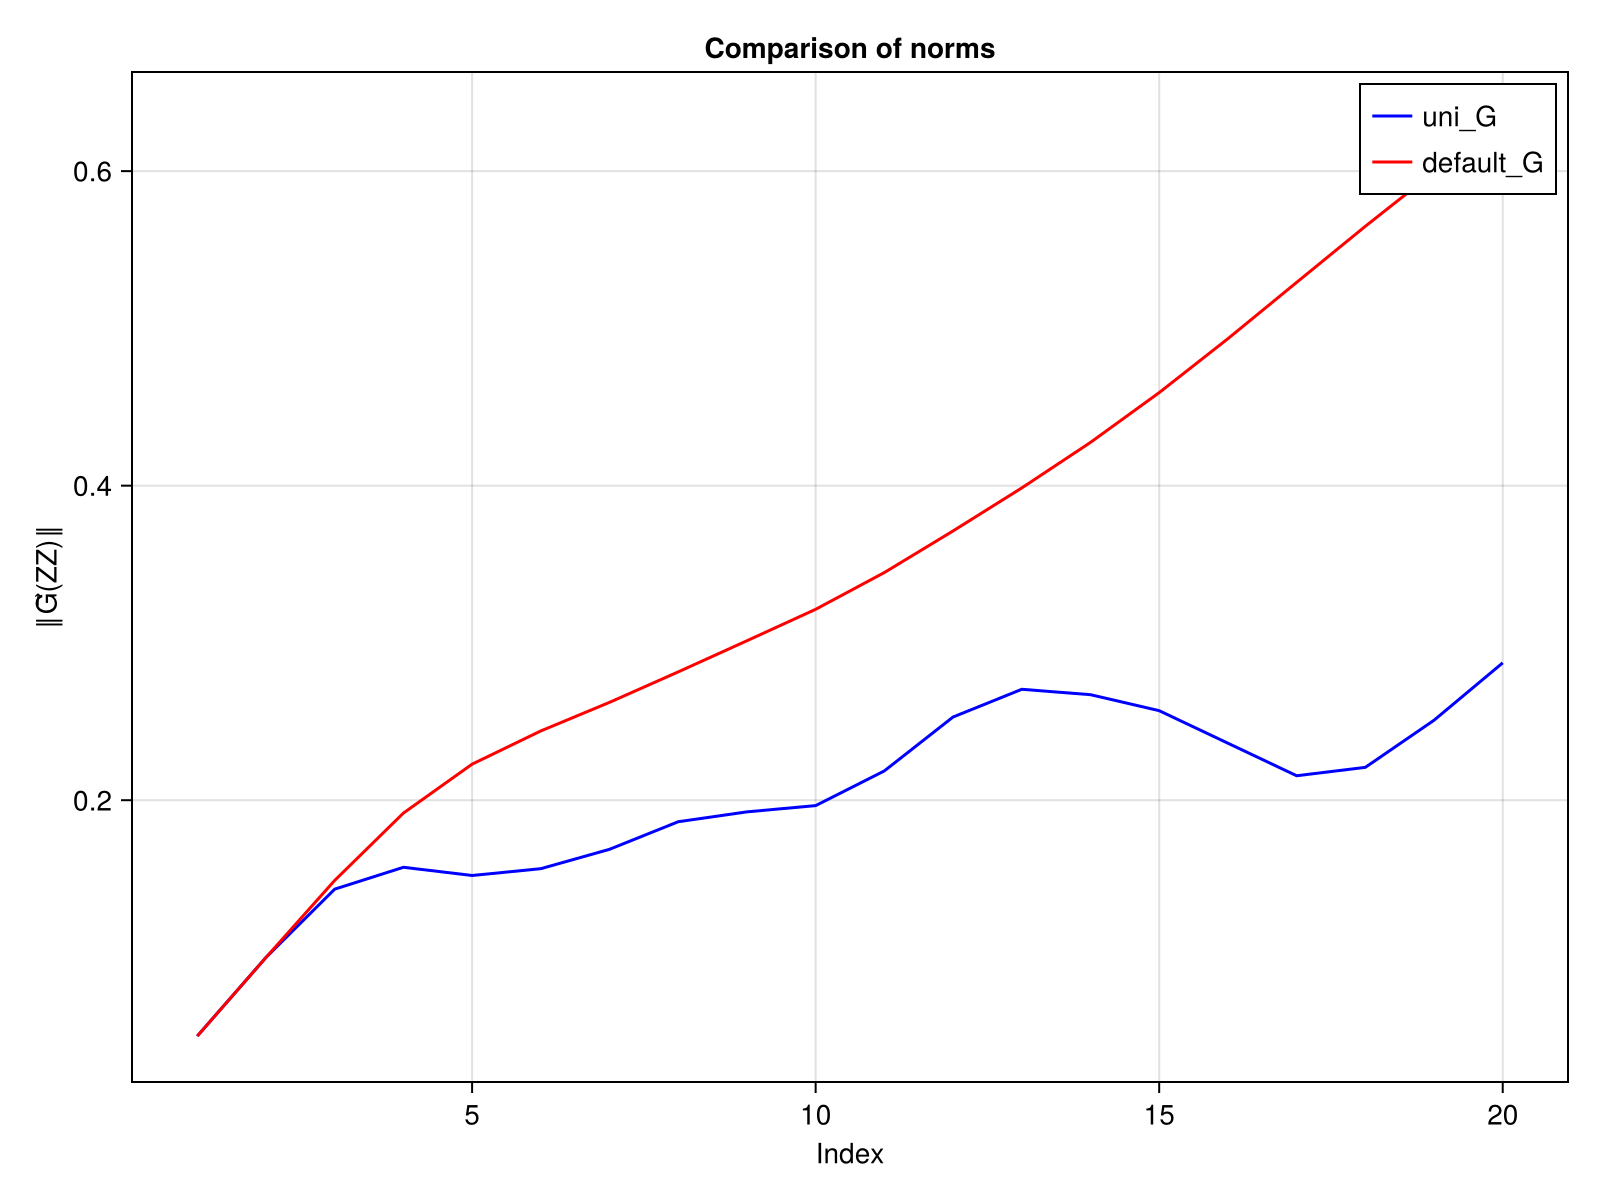

In [37]:
Hₑ = ZZ
uni_curve = SpaceCurve(uni_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)
uni_G     = [norm(v) for v in uni_curve]
default_G = [norm(v) for v in default_curve]

# x-axis (just indices here, but you can use a time vector if you have one)
xs = 1:length(uni_G)

f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Index", ylabel = "‖G⃗(ZZ)‖", title = "Comparison of norms")

lines!(ax, xs, uni_G;     color = :blue, label = "uni_G")
lines!(ax, xs, default_G; color = :red,  label = "default_G")

axislegend(ax; position = :rt)

f


In [28]:
Hₑ = YY
last_uni = []
last_def = []
for pauli in pauli_strings
    #print(Hₑ)
    uni_curve = SpaceCurve(uni_traj, U_goal, pauli)
    default_curve = SpaceCurve(default_traj, U_goal, pauli)
    uni_G     = [norm(v) for v in uni_curve]
    default_G = [norm(v) for v in default_curve]
    v = copy(uni_G[end])
    println(v)
    w = copy(default_G[end])
    push!(last_uni, v)
    push!(last_def, w)
end

0.43675509496875387
0.20938808731640743
0.20392424556258085
0.1822661841882126
0.3489891756886872
0.3172352431111864
0.2714230200125548
0.15658134211079797
0.2873536134306924


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/scenes.jl:238


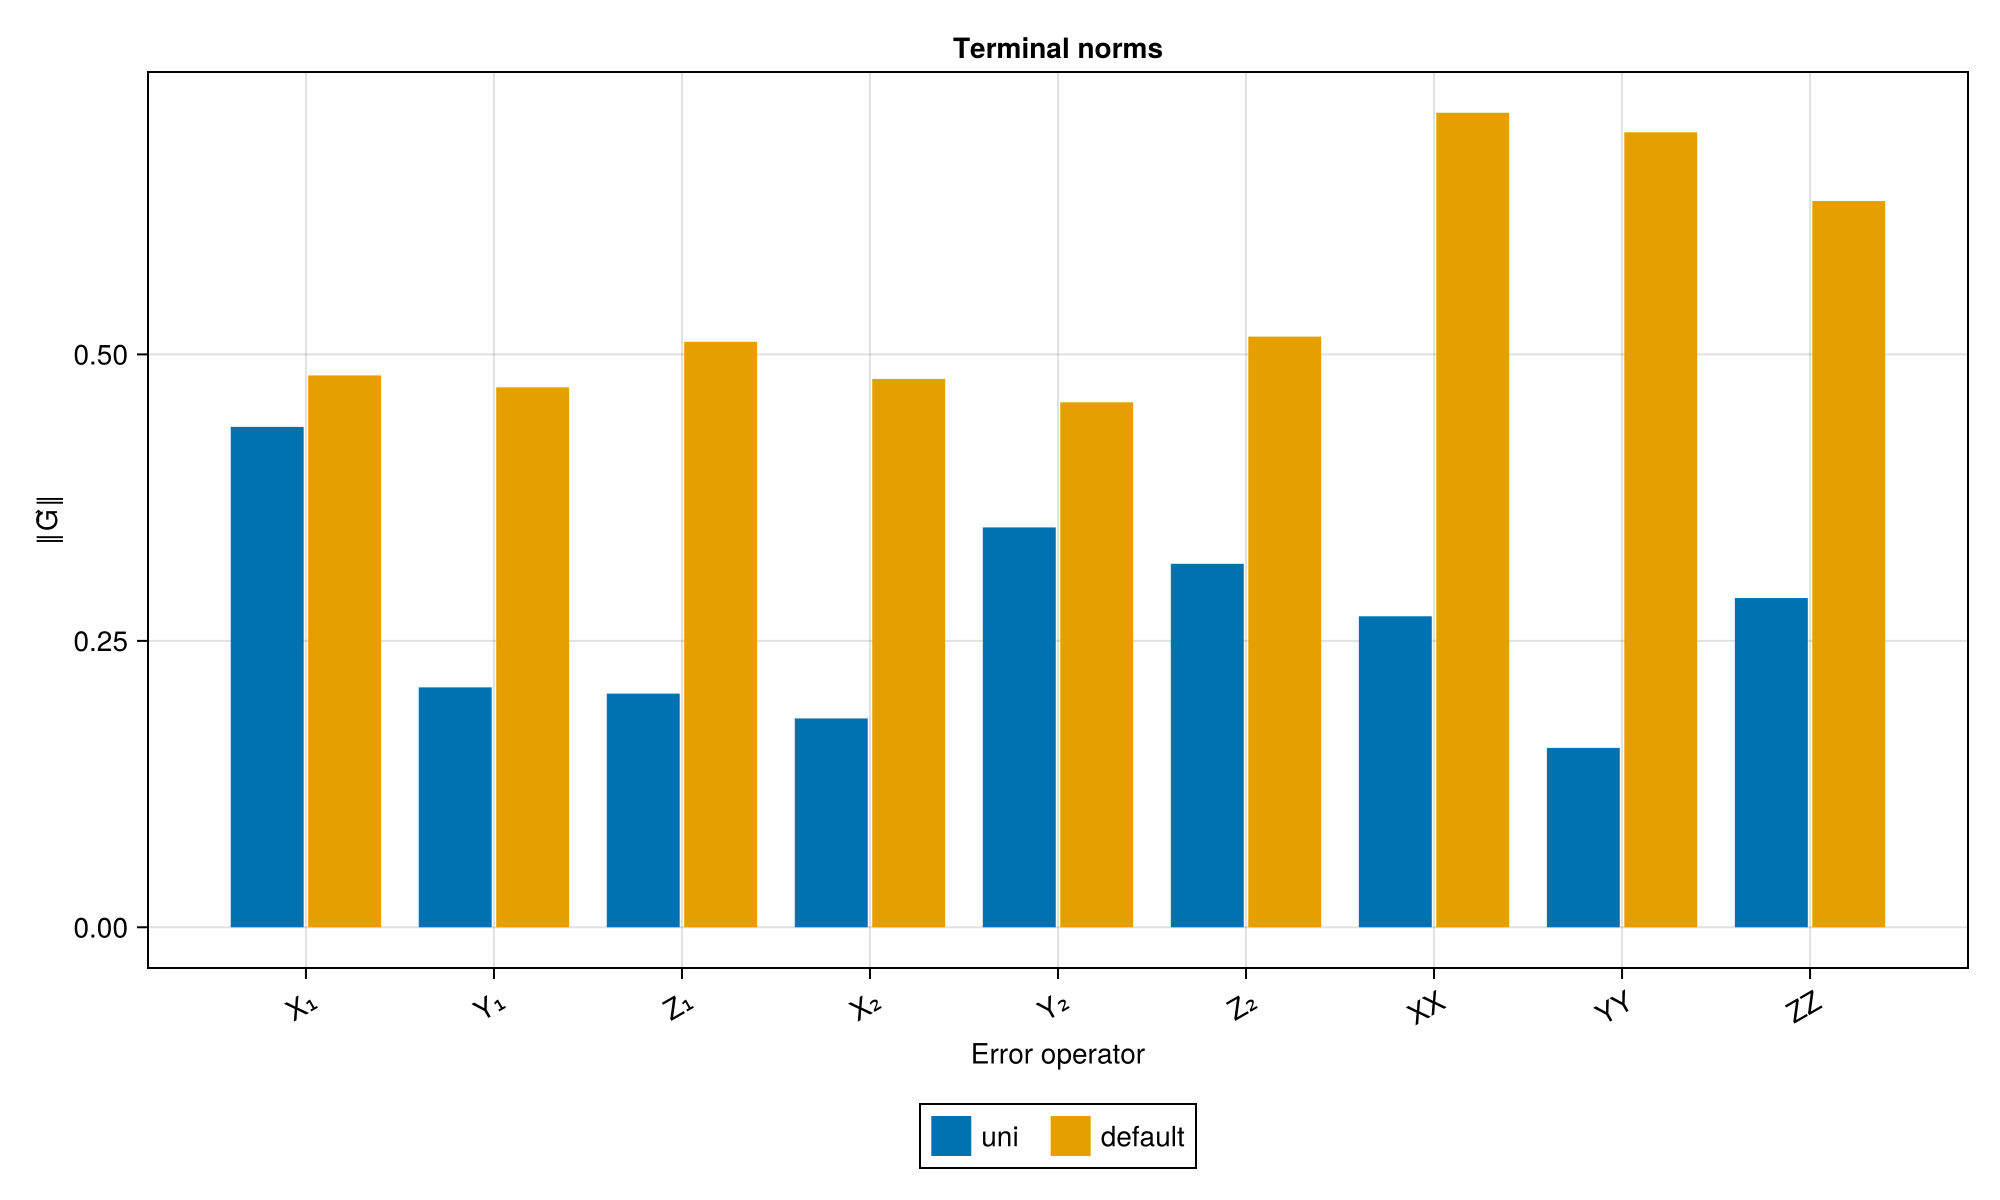

In [41]:
using CairoMakie

err_labels = ["X₁","Y₁","Z₁","X₂","Y₂","Z₂","XX","YY","ZZ"]

n = length(err_labels)

# Interleave y as [u1,d1,u2,d2,...,un,dn]
y = collect(Iterators.flatten((last_uni[i], last_def[i]) for i in 1:n))

x = repeat(1:n, inner = 2)   # [1,1,2,2,3,3,...]
g = repeat(1:2, outer = n)   # [1,2,1,2,1,2,...]  (1=uni, 2=default)

palette   = Makie.wong_colors()
colors    = [palette[1], palette[2]]
barcolors = colors[g]

f = Figure(resolution = (1000, 600))
ax = Axis(f[1, 1];
    xticks = (1:n, err_labels),
    xlabel = "Error operator",
    ylabel = "‖G⃗‖",
    title  = "Terminal norms",
    xticklabelrotation = π/6,
)

barplot!(ax, x, y; dodge = g, color = barcolors, gap = 0.2)

Legend(f[2, 1],
    [PolyElement(color = colors[1]), PolyElement(color = colors[2])],
    ["uni", "default"];
    orientation = :horizontal)

f

In [ ]:
last_def

In [ ]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

uni_curve     = SpaceCurve(uni_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(uni_curve)
x2, y2, z2 = to_xyz(default_curve)
#x3, y3, z3 = to_xyz(var_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)
#pushfirst!(x3, 0.0)
#pushfirst!(y3, 0.0)
#pushfirst!(z3, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "universal")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")
#CM.lines!(ax, x3, y3, z3; linewidth = 2.5, linestyle = :dot, color = :purple, label = "variational")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)
#CM.scatter!(ax, [x3[1]],  [y3[1]],  [z3[1]];  markersize = 10, color = :purple)
#CM.scatter!(ax, [x3[end]],[y3[end]],[z3[end]]; markersize = 10, color = :purple)

CM.axislegend(ax; position = :rb)

display(f)

     

In [ ]:
using CairoMakie
const CM = CairoMakie

function curves_for(He_sym)
    global Hₑ = He_sym
    uni_curve     = SpaceCurve(uni_traj,     U_goal, He_sym)
    default_curve = SpaceCurve(default_traj, U_goal, He_sym)
    return uni_curve, default_curve
end

function plot_pair!(pos, He_sym, ttl)
    uni_curve, default_curve = curves_for(He_sym)

    x1,y1,z1 = to_xyz(uni_curve)
    x2,y2,z2 = to_xyz(default_curve)
    #x3,y3,z3 = to_xyz(var_curve)

    pushfirst!(x1,0.0); pushfirst!(y1,0.0); pushfirst!(z1,0.0)
    pushfirst!(x2,0.0); pushfirst!(y2,0.0); pushfirst!(z2,0.0)
    #pushfirst!(x3,0.0); pushfirst!(y3,0.0); pushfirst!(z3,0.0)

    ax = CM.Axis3(pos; xlabel="X", ylabel="Y", zlabel="Z", title=ttl, aspect=:data)
    CM.lines!(ax, x1,y1,z1; linewidth=2.5, color=:dodgerblue, label="universal")
    CM.lines!(ax, x2,y2,z2; linewidth=2.5, linestyle=:dash, color=:tomato, label="default")
    #CM.lines!(ax, x3,y3,z3; linewidth=2.5, linestyle=:dot, color=:purple, label="variational")
    CM.scatter!(ax, [x1[1]], [y1[1]], [z1[1]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x1[end]], [y1[end]], [z1[end]]; markersize=10, color=:dodgerblue)
    CM.scatter!(ax, [x2[1]], [y2[1]], [z2[1]]; markersize=10, color=:tomato)
    CM.scatter!(ax, [x2[end]], [y2[end]], [z2[end]]; markersize=10, color=:tomato)
    #CM.scatter!(ax, [x3[1]], [y3[1]], [z3[1]]; markersize=10, color=:purple)
    #CM.scatter!(ax, [x3[end]], [y3[end]], [z3[end]]; markersize=10, color=:purple)
    CM.axislegend(ax; position=:rt)
    return ax
end

f = CM.Figure(size=(1400, 500))
plot_pair!(f[1,1], XX, "Hₑ = X")
plot_pair!(f[1,2], YY, "Hₑ = Y")
plot_pair!(f[1,3], ZZ, "Hₑ = Z")
display(f)

In [ ]:
ket_0 = [1.0, 1.0] ⊗ [1.0, 0.0] / sqrt(2)

In [ ]:
ket_0 = [1.0, 1.0] ⊗ [0.0, 1.0] / sqrt(2)

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(X1 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_y = [real(tr(Y1 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_z = [real(tr(Z1* iso_vec_to_operator(uni_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(uni_traj.Ũ⃗[:, t])')) for t in 1:uni_traj.T]
expect_val_x_1 = [real(tr(X1 * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(Y1 * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(Z1 * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]

     

In [ ]:
using CairoMakie
using GeometryBasics

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|0⟩ to |+⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

f
     